The general autoencoder structure was taken from: https://www.tensorflow.org/tutorials/generative/autoencoder and used for this file

In [19]:
#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from music21 import stream,note

In [20]:
#Read processed songs from file and store in an array
songs_reshaped = pd.read_csv('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/all_songs_no_time.csv',delimiter=',',header=None).to_numpy(dtype='float32')

#Reshape songs so that each sample has a length of 64 (4 beats)
songs = songs_reshaped.reshape(-1,64,128).astype('float32')

#Remove notes that occur <100 times to reduce sample size
songs = songs[:,:,30:90]
songs.shape

(5688, 64, 60)

In [21]:
#Delete any sample that may contain only zeros after resizing
zero_images = np.empty(0).astype('int')
for i in range(songs.shape[0]):
    if np.all(songs[i]==0):
        zero_images = np.append(zero_images,i)
songs_nz = np.delete(songs,zero_images,axis=0)

In [22]:
#Split the dataset into train and test. Keep random state=1 for repeatable results
x_train,x_test = train_test_split(songs_nz, test_size = 0.25, random_state = 1)


In [23]:
#Replaces -1s representing hold notes with 0.5. For use with Relu activation functions.
x_train_norm = np.where(x_train==-1,0.5,x_train)
x_test_norm = np.where(x_test==-1,0.5,x_test)

In [24]:
x_train = x_train.reshape(-1,64,60,1).astype('float32')
x_test = x_test.reshape(-1,64,60,1).astype('float32')

In [25]:
#The latent vector dimension to compress the input into
latent_dim = 128

In [26]:
#Define the encoder model in a function
def encoder():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(16,kernel_size = (3,3), input_shape = (64,60,1),padding = 'same',activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(latent_dim))
    return(model)
# enc = encoder()
# enc.build()
# enc.summary()
# plot_model(enc,show_shapes=True)

In [27]:
#Define the decoder model in a function
def decoder():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*60*16, activation='tanh', input_shape = (latent_dim,)))
    model.add(layers.Reshape(target_shape = (64,60,16)))
    model.add(layers.Conv2DTranspose(16, kernel_size = (3,3), padding = 'same',activation='tanh'))
    model.add(layers.Conv2DTranspose(1, kernel_size = (3,3), padding='same'))
    return(model)
# dec = decoder()
# dec.build()
# dec.summary()
# plot_model(dec,show_shapes=True)

In [28]:
#Define a model class called Autoencoder that is trained
class Autoencoder(Model):
    def __init__(self, latent_dim,encoder,decoder):
        super(Autoencoder,self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [29]:
#Call Autoencoder
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(latent_dim,enc,dec)

#Create optimizer and set learning rate
opt = tf.keras.optimizers.Adam(learning_rate = 5e-4)

#Compile model, set loss as mean squared error
autoencoder.compile(optimizer=opt, loss='mse')

In [30]:
#Define an early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode = "min", min_delta = 5e-5, restore_best_weights = True)

#Train the model
autoencoder.fit(x_train, x_train, batch_size = 128, epochs=100,validation_data=(x_test, x_test), callbacks = [early_stop])

Epoch 1/100
33/33 [==============================] - 2s 30ms/step - loss: 0.0346 - val_loss: 0.0251
Epoch 2/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0205 - val_loss: 0.0177
Epoch 3/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 4/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 5/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 6/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0128 - val_loss: 0.0135
Epoch 7/100
33/33 [==============================] - 1s 19ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 8/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0134
Epoch 9/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0125 - val_loss: 0.0134
Epoch 10/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0125 - val_loss: 0.0134

33/33 [==============================] - 1s 19ms/step - loss: 3.9075e-04 - val_loss: 0.0045
Epoch 81/100
33/33 [==============================] - 1s 20ms/step - loss: 3.8592e-04 - val_loss: 0.0045
Epoch 82/100
33/33 [==============================] - 1s 20ms/step - loss: 3.9077e-04 - val_loss: 0.0045
Epoch 83/100
33/33 [==============================] - 1s 20ms/step - loss: 3.8921e-04 - val_loss: 0.0045
Epoch 84/100
33/33 [==============================] - 1s 19ms/step - loss: 3.8095e-04 - val_loss: 0.0045
Epoch 85/100
33/33 [==============================] - 1s 21ms/step - loss: 3.8104e-04 - val_loss: 0.0044
Epoch 86/100
33/33 [==============================] - 1s 20ms/step - loss: 3.6359e-04 - val_loss: 0.0044
Epoch 87/100
33/33 [==============================] - 1s 21ms/step - loss: 3.5913e-04 - val_loss: 0.0044
Epoch 88/100
33/33 [==============================] - 1s 20ms/step - loss: 3.4847e-04 - val_loss: 0.0044
Epoch 89/100
33/33 [==============================] - 1s 20ms/step -

In [31]:
encoded_sngs = autoencoder.encoder(x_test).numpy()
decoded_sngs = autoencoder.decoder(encoded_sngs).numpy()
# decoded_sngs = autoencoder.predict(x_test[0:10])

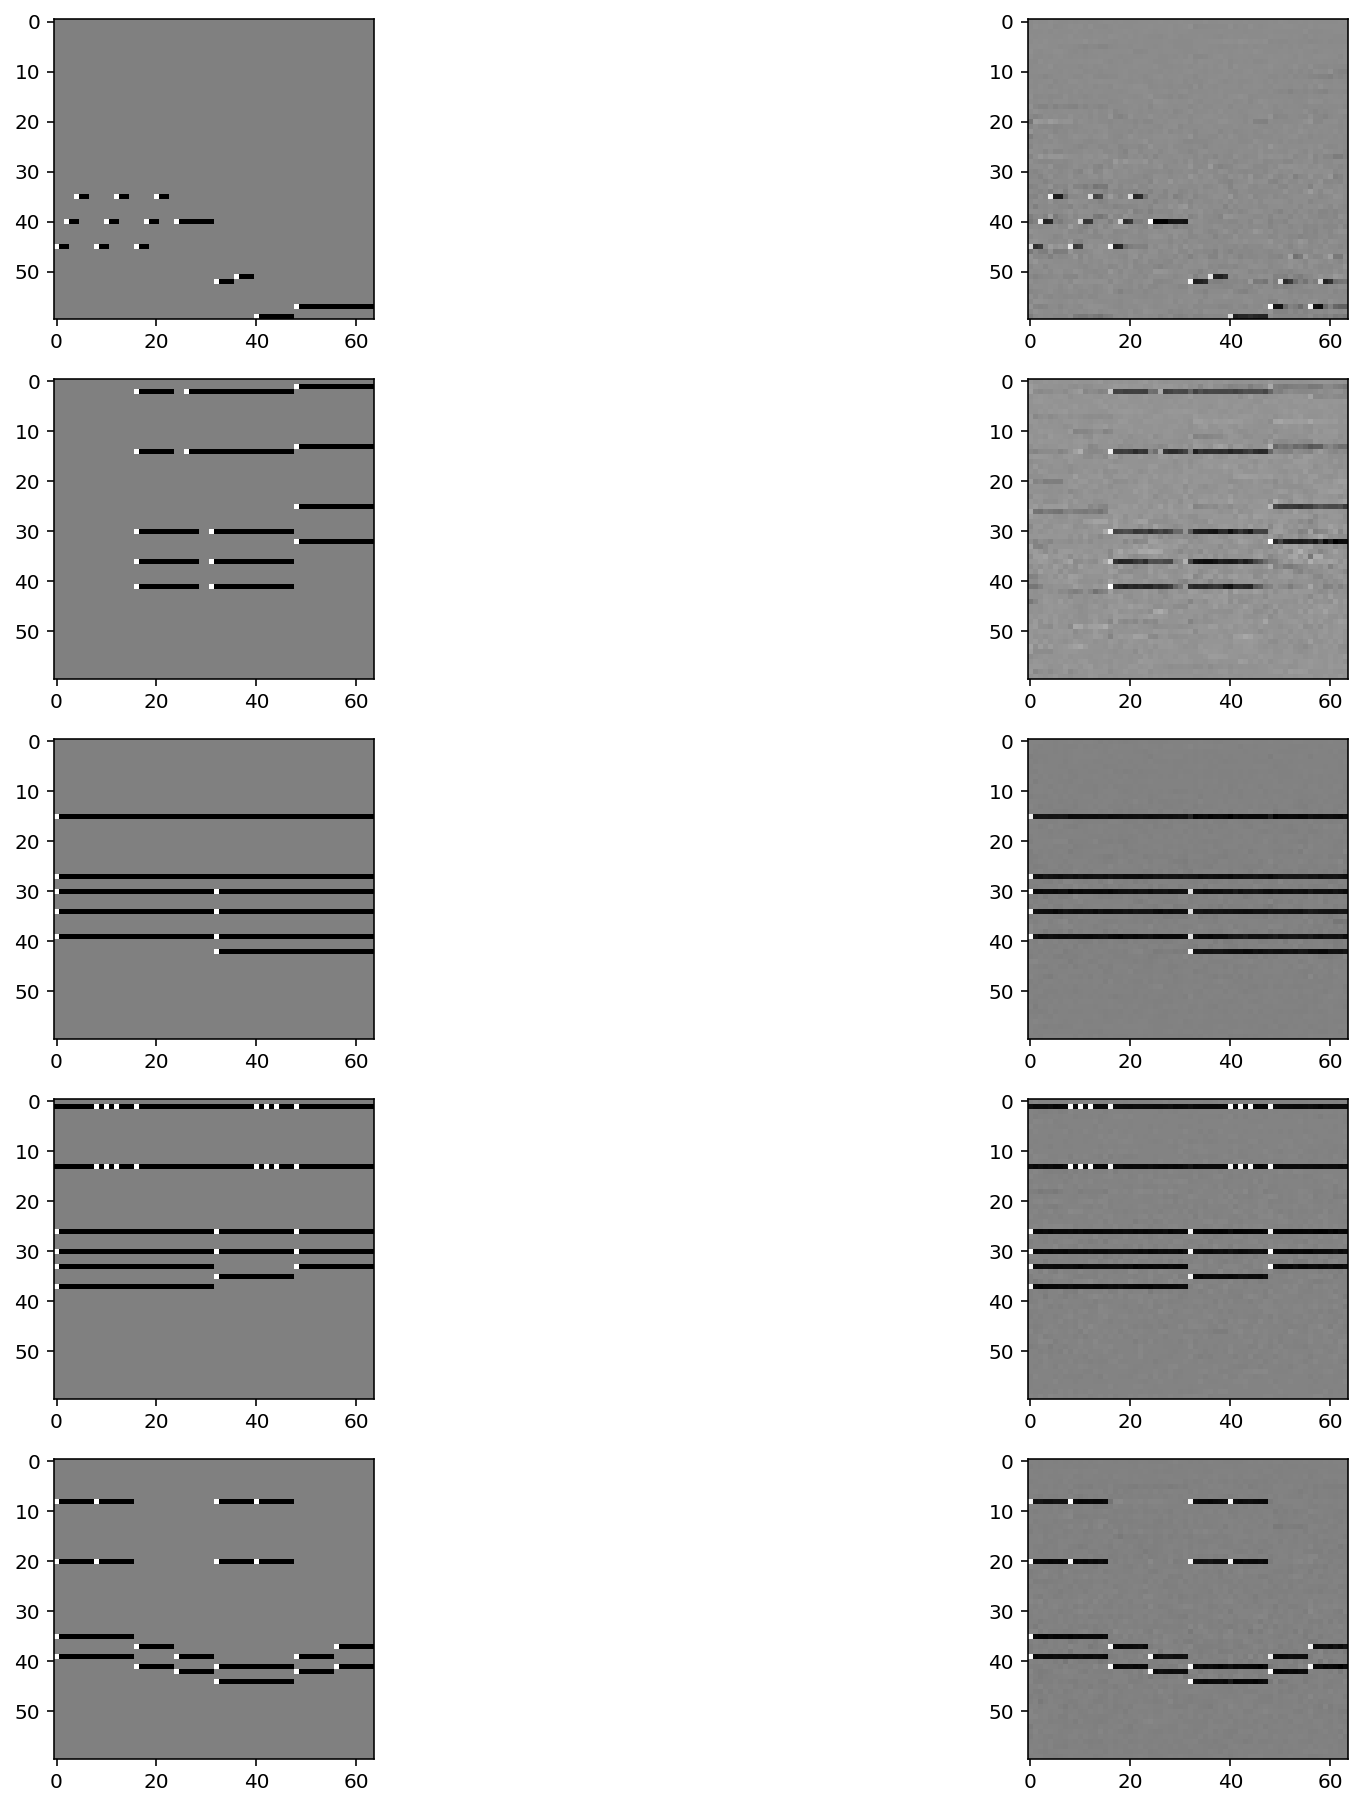

In [32]:
#Show first 5 original vs reconstructed samples
plt.figure(figsize=(16, 16))

for i in range(1,11,2):
    plt.subplot(5,2,i)
    plt.imshow(x_test[int((i-1)/2),:,:,0].transpose(),cmap='gray')
    plt.subplot(5,2,i+1)
    plt.imshow(decoded_sngs[int((i-1)/2),:,:,0].transpose(),cmap='gray')
#plt.imshow(decoded_sngs[1].transpose())

In [284]:
#What happens if we apply a random seed to the decoder?
seed = tf.random.normal([100, latent_dim], mean = enc_mean, stddev=enc_stdv)
generated_songs = autoencoder.decoder(seed).numpy()
plt.imshow(generated_songs[0,:,:,0].transpose())